In [1]:
# Install necessary libraries
!pip install torch torchvision matplotlib


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt


In [3]:
class Generator(nn.Module):
    def __init__(self, in_channels, num_features):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_features, in_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, num_features):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, num_features, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_features, num_features * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(num_features * 2, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)



In [16]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
            nn.init.constant_(m.bias.data, 0)

def create_image_pyramid(image, scales):
    pyramid = [image]
    for scale in range(1, scales):
        # Get image dimensions using image.shape instead of image.size
        _, _, height, width = image.shape  # Unpack the shape correctly
        # Ensure output dimensions are greater than 0
        new_height = max(1, int(height / (2 ** scale)))
        new_width = max(1, int(width / (2 ** scale)))
        downsampled = transforms.Resize((new_height, new_width))(image)
        pyramid.append(downsampled)
    return pyramid

In [7]:
def adversarial_loss(real, fake):
    return torch.mean((real - 1) ** 2) + torch.mean(fake ** 2)

def reconstruction_loss(real, reconstructed):
    return nn.MSELoss()(real, reconstructed)


In [8]:
def train_single_scale(generator, discriminator, image, optimizer_G, optimizer_D, num_epochs, device):
    for epoch in range(num_epochs):
        noise = torch.randn(1, 3, image.size(2), image.size(3)).to(device)
        fake_image = generator(noise)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_score = discriminator(image)
        fake_score = discriminator(fake_image.detach())
        d_loss = adversarial_loss(real_score, fake_score)
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_score = discriminator(fake_image)
        g_loss = -torch.mean(fake_score)
        g_loss.backward()
        optimizer_G.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    return generator, discriminator


In [34]:
image_path = '/content/ORIGINALIMGjpg'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0).to(device)


In [35]:
num_scales = 6
image_pyramid = create_image_pyramid(image, num_scales)

generators = []
discriminators = []
for scale, img in enumerate(image_pyramid):
    print(f"Training Scale {scale + 1}/{num_scales}")
    generator = Generator(in_channels=3, num_features=32).to(device)
    discriminator = Discriminator(in_channels=3, num_features=32).to(device)
    initialize_weights(generator)
    initialize_weights(discriminator)

    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    generator, discriminator = train_single_scale(
        generator, discriminator, img, optimizer_G, optimizer_D, num_epochs=2000, device=device
    )

    generators.append(generator)
    discriminators.append(discriminator)


Streaming output truncated to the last 5000 lines.
Epoch [1004/2000] | D Loss: 0.0106 | G Loss: -0.0523
Epoch [1005/2000] | D Loss: 0.0091 | G Loss: -0.0458
Epoch [1006/2000] | D Loss: 0.0110 | G Loss: -0.0481
Epoch [1007/2000] | D Loss: 0.0101 | G Loss: -0.0492
Epoch [1008/2000] | D Loss: 0.0076 | G Loss: -0.0409
Epoch [1009/2000] | D Loss: 0.0090 | G Loss: -0.0471
Epoch [1010/2000] | D Loss: 0.0078 | G Loss: -0.0390
Epoch [1011/2000] | D Loss: 0.0075 | G Loss: -0.0401
Epoch [1012/2000] | D Loss: 0.0137 | G Loss: -0.0570
Epoch [1013/2000] | D Loss: 0.0102 | G Loss: -0.0487
Epoch [1014/2000] | D Loss: 0.0075 | G Loss: -0.0393
Epoch [1015/2000] | D Loss: 0.0133 | G Loss: -0.0539
Epoch [1016/2000] | D Loss: 0.0092 | G Loss: -0.0444
Epoch [1017/2000] | D Loss: 0.0103 | G Loss: -0.0587
Epoch [1018/2000] | D Loss: 0.0103 | G Loss: -0.0469
Epoch [1019/2000] | D Loss: 0.0093 | G Loss: -0.0474
Epoch [1020/2000] | D Loss: 0.0076 | G Loss: -0.0434
Epoch [1021/2000] | D Loss: 0.0070 | G Loss: -0.

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 64, 1, 1])

In [36]:
clipart = Image.open('/content/mountain-and-lake-landscape-vector.jpg').convert('RGB')
transform = transforms.Compose([
    transforms.Resize((image.size(2) // 4, image.size(3) // 4)),  # Resize to match coarse scale
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
clipart = transform(clipart).unsqueeze(0).to(device)


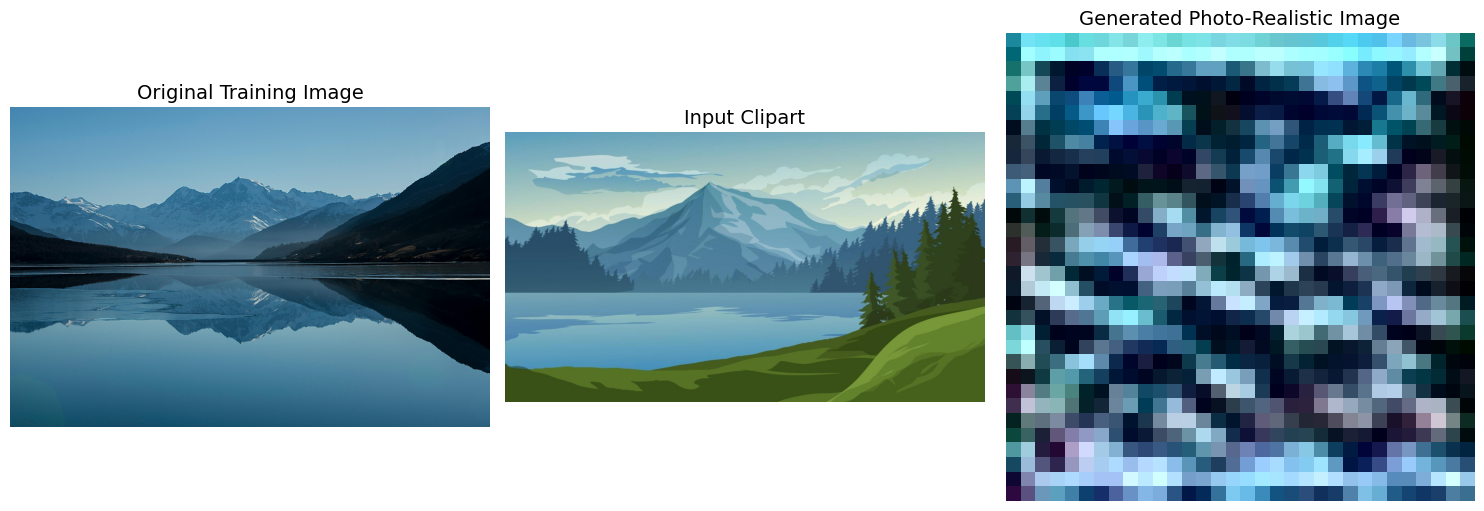

In [37]:
# Load the training image
training_image = Image.open('/content/ORIGINALIMGjpg')

# Load the clipart
clipart_image = Image.open('/content/mountain-and-lake-landscape-vector.jpg')

def display_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=14)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

start_scale = len(generators) - 2
current_input = transform(clipart_image).unsqueeze(0).to(device)
for i in range(start_scale, len(generators)):
    noise = torch.randn_like(current_input).to(device)
    current_input = generators[i](noise + current_input)

save_image(current_input, 'photo_realistic_image.jpg', normalize=True)
generated_image = Image.open('photo_realistic_image.jpg')

display_images(
    [training_image, clipart_image, generated_image],
    ["Original Training Image", "Input Clipart", "Generated Photo-Realistic Image"]
)
